# CMI - predictions on labeled data with ensemble voting
Here, I train only the subset of ```train.csv``` that contains the ```sii``` labels using boosted regressors (XGBoost, LightGBM and CatBoost). Even though the ```sii``` label is categorical, the ordinal nature of the label means that the class probability thresholds become important and the classification task can actually be approached using regression, with a rounding-off mechanism for making the final predictions. This notebook contains the following -
1. **Time-series statistics extraction:** Simple statistics from the time-series parquet files are calculated, extracted and appended to the ```train.csv``` and ```test.csv``` files. The time-series statistics can be parallelized in many ways. Here, it is done using ```joblib```.
2. **Cross-validation:** The data is trained and validated in a ```StratifiedKFold``` training and validation loop. I make sure to perform the required data preprocessing steps, imputation and scaling (if required), inside this loop to prevent *data leakage*. In this way, the data preprocessing pipeline can be ```fit_transform()```'d on the training set, while the validation and test sets are only ```transform()```'d. Inside the cross-validation loop, the different regressor models are fitted and the out-of-fold (OOF) predictions are calculated. Importantly, optimal thresholds for rounding-off these predictions to ordinal variables is performed.
3. **Hyperparameter Optimization:** The hyperparameter optimization was performed using ```Optuna``` and they are only stated here.

In [1]:
import glob
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.base import clone 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix, f1_score, classification_report
import optuna

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

sns.set_theme()

## Data extraction
The training and test data consist of ```.csv``` files containing tabular data of over $3,000$ participants. Furthermore, the dataset also contains actigraphy data stored in ```.parquet``` files for a certain subset of participants in the form of tabular time-series.

In [2]:
folder_path = './../child-mind-institute-problematic-internet-use/'

train_df = pd.read_csv(folder_path + 'train.csv', index_col='id')
test_df = pd.read_csv(folder_path + 'test.csv', index_col='id')
data_dict = pd.read_csv(folder_path + 'data_dictionary.csv')

timeseries_train_files = glob.glob(folder_path + 'series_train.parquet/*')
timeseries_test_files = glob.glob(folder_path + 'series_test.parquet/*')

### Extracting time-series features and statistics
The actigraphy data contains a wealth of information that can be extremely helpful at predicting problematic internet usage among children and adolescents. In particular, the time-series data contains the ```enmo``` feature, which is a generalized notion of the acceleration experienced by the user's hand. Statistics of such variables, especially during the weekends, can help strenghten the training dataset, allowing for more robust predictive modeling. The ```extract_timeseries_features()``` function has been adapted from Lennard Haupt's notebook in https://www.kaggle.com/code/lennarthaupts/cmi-detecting-problematic-digital-behavior. I plan on performing a different statistical analysis on the actigraphy data later.

In [3]:
def extract_timeseries_features(df):
    ''' 
    Extracting time-series features from the actigraphy datasets.
    Copied from Lennard Haupt's notebook in https://www.kaggle.com/code/lennarthaupts/cmi-detecting-problematic-digital-behavior
    '''

    # Converting time_of_day to hours; the time_of_day variable is expressed in nanoseconds
    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)

    # Define conditions for night, day, and no mask (full data); night is defined to be between hours 22 and 5
    night = ((df["hours"] >= 22) | (df["hours"] <= 5))
    day = ((df["hours"] <= 20) & (df["hours"] >= 7))
    no_mask = np.ones(len(df), dtype=bool)
    # Define weekend and last week conditions
    weekend = (df["weekday"] >= 6)
    last_week = df["relative_date_PCIAT"] >= (df["relative_date_PCIAT"].max() - 7)
    # Create additional weekend features
    df["enmo_weekend"] = df["enmo"].where(weekend)
    df["anglez_weekend"] = df["anglez"].where(weekend)
    # Basic features 
    features = [
        df["non-wear_flag"].mean(),
        df["battery_voltage"].mean(),
        df["battery_voltage"].diff().mean(),
        df["relative_date_PCIAT"].tail(1).values[0]
    ]
    
    # List of columns of interest and masks
    keys = ["enmo", "anglez", "light", "enmo_weekend", "anglez_weekend"]
    masks = [no_mask, night, day, last_week]
    
    # Helper function for feature extraction
    def extract_stats(data):
        return [
            data.mean(), 
            data.std(), 
            data.max(), 
            data.min(), 
            data.kurtosis(), 
            data.skew(), 
            data.diff().mean(), 
            data.diff().std(), 
            data.diff().quantile(0.9), 
            data.diff().quantile(0.1)
        ]
    
    # Iterate over keys and masks to generate the statistics
    for key in keys:
        for mask in masks:
            filtered_data = df.loc[mask, key]
            features.extend(extract_stats(filtered_data))

    return features

def process_file(filepath):
    ''' 
    This function takes the filepath of a time-series parquet file and extracts the id number and the
    statistics defined in extract_timeseries_features() function.
    '''
    df = pd.read_parquet(filepath)
    df.drop('step', axis=1, inplace=True)

    features = extract_timeseries_features(df)
    id_num = filepath.split('=')[-1]

    return features, id_num

def extract_timeseries_id(filepath_array):
    ''' 
    This function takes an array of filepaths and returns an array of id numbers.
    '''
    id_list = []
    for n, folder in enumerate(filepath_array):
        id = folder.split('=')[-1]
        id_list.append(id)

    return id_list 

def timeseries_features_df(filepath_array, n_jobs=8):
    ''' 
    This function takes as input a filepath array and returns a dataframe with all the time-series statistics for each parquet file.
    The extraction process is sped up using Python's joblib library, with n_jobs being an optional argument.
    '''
    print('Extracting features from time-series files.')
    results = Parallel(n_jobs=n_jobs)(delayed(process_file)(f) for f in tqdm(filepath_array))

    stats, indices = zip(*results)
    df = pd.DataFrame(stats, columns=[f'stat_{i}' for i in range(len(stats[0]))])
    df['id'] = indices

    return df

The time-series statistics from the train and test parquet files are extracted into ```train_timeseries``` and ```test_timeseries``` dataframes. These are then merged with the data from the csv files.

In [4]:
train_timeseries = timeseries_features_df(timeseries_train_files)
test_timeseries = timeseries_features_df(timeseries_test_files)

Extracting features from time-series files.


100%|██████████| 996/996 [00:33<00:00, 29.97it/s]


Extracting features from time-series files.


100%|██████████| 2/2 [00:00<00:00, 1537.50it/s]


In [5]:
timeseries_cols = train_timeseries.columns.tolist()
timeseries_cols.remove('id')

train_df_merged = pd.merge(train_df, train_timeseries, how='left', on='id')
test_df_merged = pd.merge(test_df, test_timeseries, how='left', on='id')

train_df_merged.set_index('id', inplace=True)
test_df_merged.set_index('id', inplace=True)

## Initial preprocessing
The different ```PCIAT``` columns are first removed from the training dataset. Then, I consider the subset of the data that has ```sii``` values associated with them. The numerical and categorical columns are then separated out. Here, the categorical columns are those features which are labeled as ```categorical int``` in ```data_dictionary.csv```. I will also remove any feature category that has 'Enrolment Season' or 'Season' in its descriptor.

In [6]:
train_cols = train_df_merged.columns.tolist()
test_cols = test_df_merged.columns.tolist()

drop_cols = list( set(train_cols) - set(test_cols) )
drop_cols.remove('sii')

train_df_subset = train_df_merged[train_df.loc[:, 'sii'].notna()]
train_df_subset.drop(columns=drop_cols, inplace=True)

X_train = train_df_subset.loc[:, train_df_subset.columns != 'sii']
y = train_df_subset['sii'].astype('Int64')
X_test = test_df_merged 

numerical_cols = data_dict[ (data_dict['Type']=='float') | (data_dict['Type']=='int') ]['Field'].tolist()
numerical_cols.remove('PCIAT-PCIAT_Total')
numerical_cols = numerical_cols + timeseries_cols

categorical_cols = data_dict[ data_dict['Type']=='categorical int' ]['Field'].tolist()
categorical_cols = [item for item in categorical_cols if (item not in drop_cols)]

After this inial preprocessing, the dataset comprises of $241$ numerical (most of which are comprised of time-series statistics extracted from the actigraphy files) and $11$ categorical features.

In [7]:
print(numerical_cols)
print(f'There are {len(numerical_cols)} numerical features.')

['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'stat_0', 'stat_1', 'stat_2', 'stat_3', 'stat_4', 'stat_5', 'stat_6', 'stat_7', 'stat_8', 'stat_9', 'stat_10', 'stat_11', 'stat_12', 'stat_13', 'stat_14', 'stat_15', 'stat_16', 'stat_17', 'stat_18', 'stat_19', 'stat_20', 'stat_21', 'stat_22', 'stat_23', 'stat_24', 'stat_25', 'stat_26', 'stat_27', 'stat_28', 'stat_2

In [8]:
print(categorical_cols)
print(f'There are {len(categorical_cols)} categorical features.')

['Basic_Demos-Sex', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PreInt_EduHx-computerinternet_hoursday']
There are 11 categorical features.


The *severity impairement index* or ```sii``` is actually derived from the ```PCIAT-Total``` test scores of the participants. Hence, there is a direct correspondence between the availability of ```PCIAT``` and ```sii``` values. The way the ```sii``` scores are determined is as follows
* $0 - 30$: ```sii=0```
* $31 - 49$: ```sii=1```
* $50 - 79$: ```sii=2```
* $80 - 100$: ```sii=3```

We can see that there is severe imbalance between the different ```sii``` classes, with ```sii``` of $0$ comprising of more than $40\%$ of the cases in the data. Hence, during cross-validation, stratification will become necessary. Even after stratification, however, the algorithm might not be able to effectively categorize ```sii``` of $3$ since it comprises of such a small proportion of the sample.

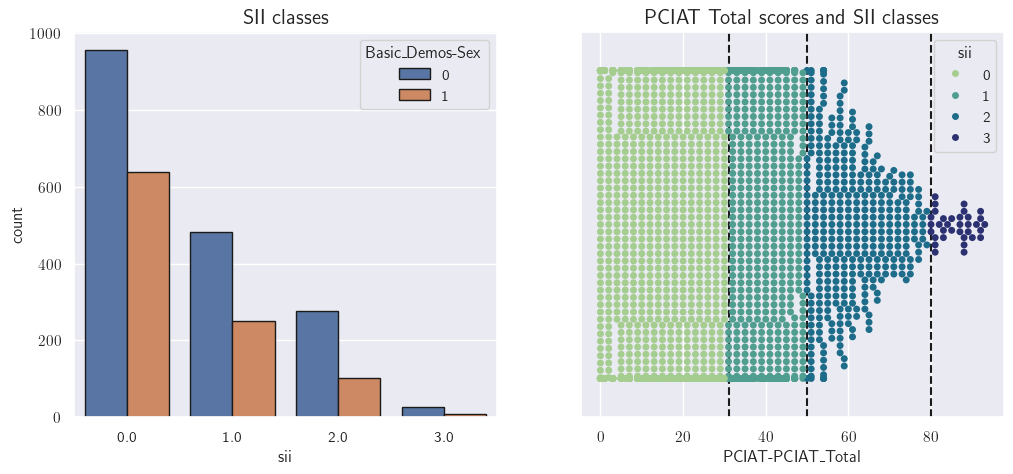

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(train_df, x='sii', hue='Basic_Demos-Sex', ax=ax[0], edgecolor='k')
ax[0].set_title('SII classes', fontsize=15)

sns.swarmplot(train_df, x='PCIAT-PCIAT_Total', hue=y, palette='crest', ax=ax[1])
ax[1].set_title('PCIAT Total scores and SII classes', fontsize=15)
ax[1].axvline(x=31, color='k', linestyle='--')
ax[1].axvline(x=50, color='k', linestyle='--')
ax[1].axvline(x=80, color='k', linestyle='--')
plt.show()

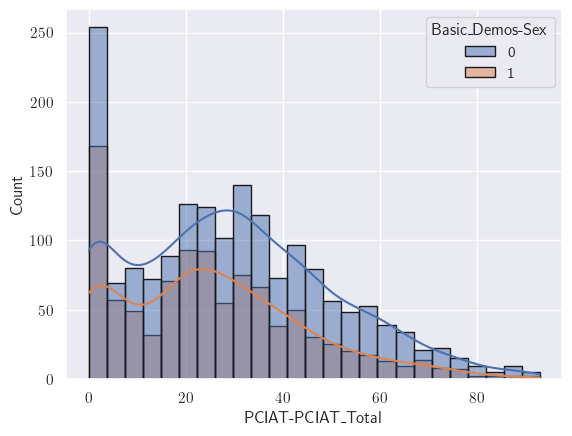

In [8]:
sns.histplot(train_df, x='PCIAT-PCIAT_Total', bins=25, hue='Basic_Demos-Sex', edgecolor='k', kde=True)
plt.show()

We can gain much better insight to the problem if we also considered binning the ```Basic_Demos-Age``` (age) feature. The ages are provided as integegers between $5$ and $22$ years. However, we can also bin this column into appropriate age groups. The ones used here are -
* Gradeschoolers: between $4$ and $11$ years old (ordinal label: $0$)
* Teens: between $12$ and $17$ years old (ordinal label: $1$)
* Young adults: between $18$ and $22$ years old (ordinal label: $2$)

It can be observed that the daily internet usage, as given by ```PreInt_EduHx-computerinternet_hoursday```, and ```sii``` can be neatly visualized in terms of these age groups, retaining the high correlation between them.

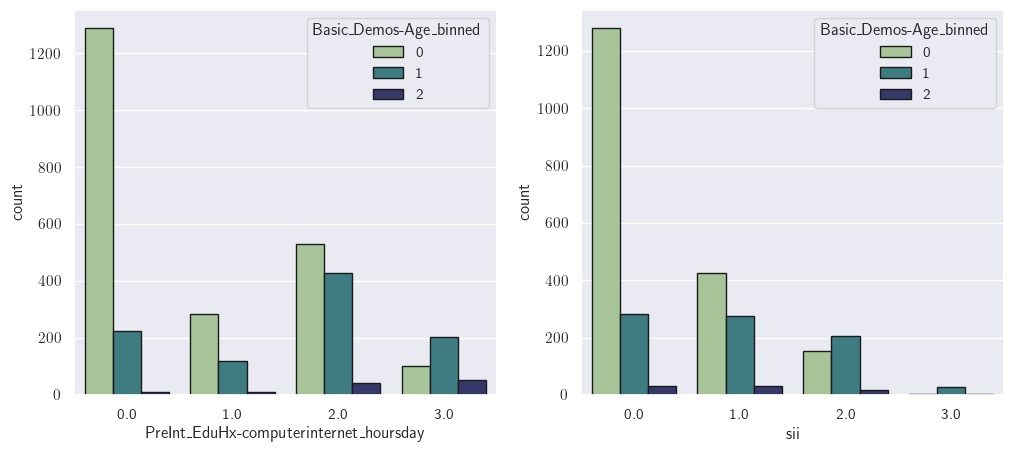

In [9]:
train_df['Basic_Demos-Age_binned'] = pd.cut(
    train_df['Basic_Demos-Age'], bins=[4, 11, 17, 25], labels=[0, 1, 2]
).astype('int32')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(train_df, x='PreInt_EduHx-computerinternet_hoursday', edgecolor='k', hue='Basic_Demos-Age_binned', palette='crest', ax=ax[0])
sns.countplot(train_df, x='sii', edgecolor='k', hue='Basic_Demos-Age_binned', palette='crest', ax=ax[1])
plt.show()

There are several features in the ```train.csv``` file (ignoring the time-series data) that have a very large proportion of missing values. It can be seen in the plot below where the features with over $60\%$ missing entries are colored in red. Imputing such features might lead to inaccurate predictions. Hence, these features can be excluded from the data.

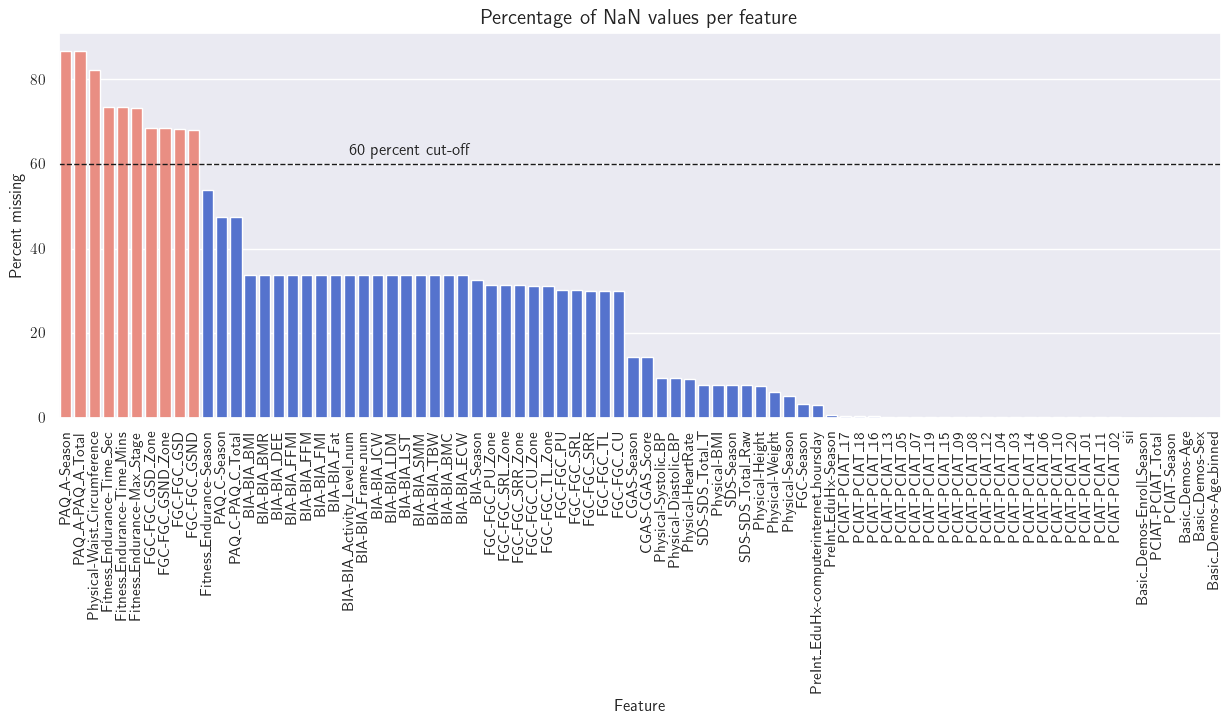

In [10]:
def plot_na(data):
    if data.isna().sum().sum() != 0: # checks if there are NaN values
        na_data = (data.isna().sum().sort_values(ascending=False))/len(data) *100
        missing_data = pd.DataFrame({'Feature': na_data.index, 'Percent missing': na_data.values})

        vals = missing_data['Percent missing'].tolist()
        colors = ['royalblue' if (x < 60) else 'salmon' for x in vals ]
        fig, ax = plt.subplots(figsize=(15, 5))
        sns.barplot(missing_data, x='Feature', y='Percent missing', palette=colors, ax=ax)
        plt.xticks(rotation=90)
        plt.annotate('60 percent cut-off', (20, 62))
        plt.axhline(y=60, color='k', linewidth=1, linestyle='--')
        ax.set_title('Percentage of NaN values per feature', fontsize=15)
    else:
        print('No missing data found.')

plot_na(train_df[train_df['sii'].notna()])

It may also be of interest to consider features that have some degree of correlation with the target. Other than the ```PCIAT``` subfeatures, on which the ```sii``` index is based, there are really no features with an extremely high degree of correlation with the target. Hence, a rather conservative cut-off is used to further winnow down on the number of features. Here, we use
$$ 0.05 \geq \text{Corr}(X_i) \geq - 0.05 $$
as those features $X_i$ to be removed.

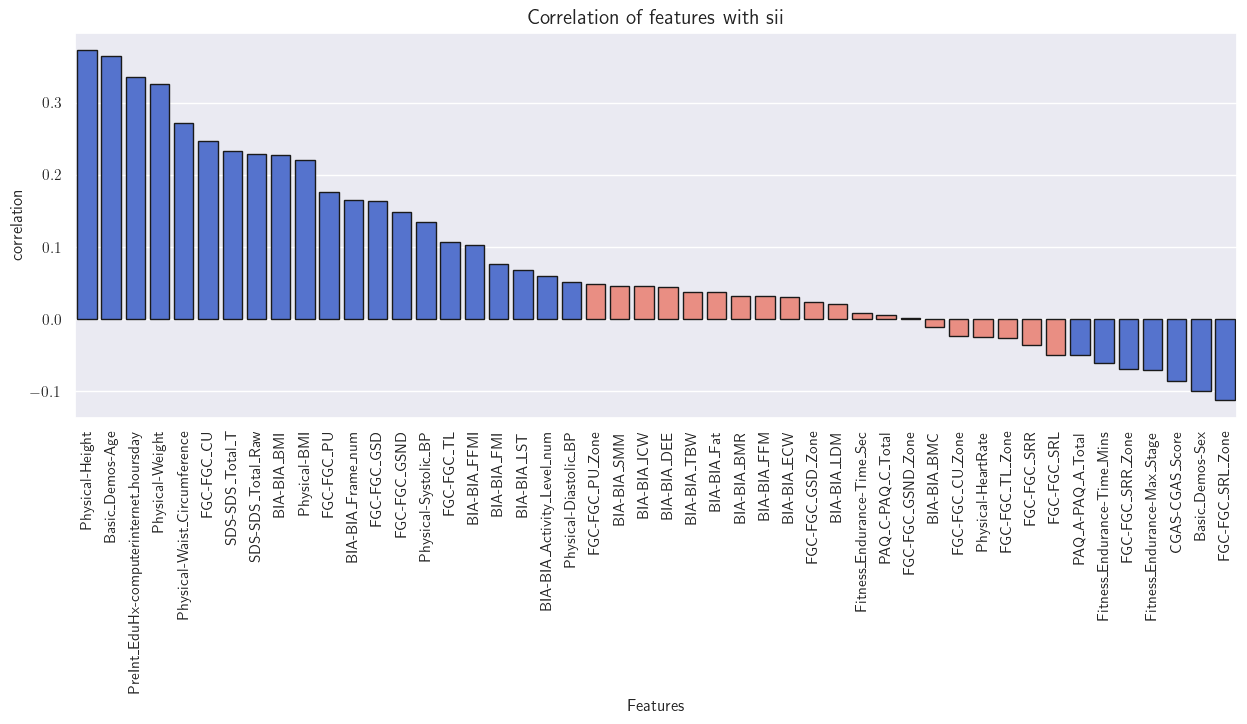

In [11]:
def plot_corr_with_sii(data):
    ''' 
    This function plots the correlation of various features with sii.
    '''
    data_numeric = data.select_dtypes(['int64', 'float64'])
    corr_matrix = data_numeric.corr() # correlation matrix

    corr_with_sii = corr_matrix.loc['sii'].sort_values(ascending=False)
    df = pd.DataFrame(
        {
            'Features': corr_with_sii.index.to_list()[1:],
            'correlation': corr_with_sii.to_list()[1:]
        }
    )
    filter = df['Features'].str.startswith('PCIAT') == False
    df = df[filter].reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(15, 5))

    vals = df['correlation'].tolist()
    colors = ['royalblue' if (x >= 0.05 or x <= -0.05) else 'salmon' for x in vals ]
    sns.barplot(df, y='correlation', x='Features', palette=colors, edgecolor='k', ax=ax)
    plt.xticks(rotation=90)
    ax.set_title('Correlation of features with sii', fontsize=15)
    plt.show()

    return df

corr_with_sii = plot_corr_with_sii(train_df) 

In [12]:
cols_high_missing = [
    'PAQ_A-PAQ_A_Total',
    'Physical-Waist_Circumference',
    'Fitness_Endurance-Time_Sec',
    'Fitness_Endurance-Time_Mins',
    'Fitness_Endurance-Max_Stage',
    'FGC-FGC_GSD_Zone',
    'FGC-FGC_GSND_Zone',
    'FGC-FGC_GSD',
    'FGC-FGC_GSND'
]

cols_low_corr = corr_with_sii[ (corr_with_sii['correlation'] < 0.05) & (corr_with_sii['correlation'] > -0.05) ]['Features'].tolist()

numerical_cols = list(set(numerical_cols) - set(cols_high_missing) - set(cols_low_corr))
categorical_cols = list(set(categorical_cols) - set(cols_high_missing) - set(cols_low_corr))

print(f'There are now {len(numerical_cols)} numerical features.')
print(f'There are now {len(categorical_cols)} categorical features.')

There are now 220 numerical features.
There are now 6 categorical features.


In [13]:
def extra_features(df):
    # binned-age
    df['Basic_Demos-Age'] = train_df['Basic_Demos-Age_binned']
    df.rename(columns={'Basic_Demos-Age':'Basic_Demos-Age_binned'}, inplace=True)

    # fat to BMI ratio
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']

    # fat-free and fat mass indices to BMI ratio
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']

    # muscle to fat ratio
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']

    # body water to weight ratio
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']

    return df

X_train = extra_features(X_train)
X_test = extra_features(X_test)

numerical_cols.remove('Basic_Demos-Age')
categorical_cols.append('Basic_Demos-Age_binned')
numerical_cols.extend(['BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'Muscle_to_Fat', 'Hydration_Status'])

## Useful functions
We define some useful functions here. 
1. ```clipped(X, r)```: This function takes in the numerical columns of the training data as input and winsorizes only those columns for which the standard deviation is much greater than the mean, expressed as the ratio $r$. This can be an effective way of winsorizing only those features that have very large outliers (some of those in the ```BIA``` category) without fixing them by hand.
2. ```process(X, num_cols, cat_cols)```: This function performs a few simple processing steps on the data such as the aforementioned winsorization on the numerical columns and replacing occurrences of zeros with column means and converting the categorical features in ```Int64```, turning them into ordinal variables.
3. ```cross_val_QWK(reg_class, X, y, num_cols, cat_cols, cv, verbose=False)```: This function performs a whole host of tasks and is responsible for performing stratified $k$-fold cross-validation and making predictions. Apart from these steps, this function also performs the following - 
    * **Data preprocessing:** This is done inside the cross-validation loop to prevent data leakage. 
    * $\kappa$ **-scores:** The weighted $\kappa$ scores are calculated for both training and validation sets at each fold using the ```quadratic_weighted_kappa(y_true, y_pred)``` function. The validation set predictions here are labeled ```oof``` (out-of -fold) for wihch there are ```oof_not_rounded``` and ```oof_rounded```, where the former arises from the fact that the model is being trained with regressors. The rounding thresholds can be the default $x_0=\left[ 0.5, 1.5, 2.5 \right]$ or a optimal set of thresholds by maximizing $\kappa$. This optimized threshold $x_{0,\text{opt}}$ is then used to round-off the mean predictions over the $k$-folds of cross-validation.
4. ```objective(trial, reg, X, y, num_cols, cat_cols, cv, verbose=False)``` and ```hyperparam_optim(reg, X, y, num_cols, cat_cols, n_trials=25, cv=5)```: These functions perform hyperparameter optimization using ```Optuna```.

In [14]:
RANDOM_SEED=10

In [25]:
def clipped(X, r):
    ''' 
    This function caps the numerical columns to the specified upper and lower quantiles on respective ends. It does so for those featutres
    for which the standard deviation is much greater or equal the mean. This is passed as a desired ratio of std/mean.
    '''
    X_clipped = X.copy()

    ratio = X_clipped.std() / X_clipped.mean()
    idx_list = ratio[ ratio.where(ratio >= r).notna() ].index.tolist()

    for idx in idx_list:
        lq = X_clipped[idx].quantile(0.05)
        uq = X_clipped[idx].quantile(0.95)
        X_clipped.loc[:, idx] = X_clipped.loc[:, idx].clip(lower=lq, upper=uq)

    return X_clipped

def process(X, num_cols, cat_cols):
    ''' 
    This function performs preprocessing on the data. The training data is first split into numerical and categorical features.
    '''
    X_numerical = X[num_cols]

    X_categorical = X[cat_cols]
    X_categorical = X_categorical.astype('Int64')

    # Some numerical features have erroneous zero values - e.g. BMI, blood pressure etc
    # Winsorize X_numerical and replace occurrences of zero with feature mean

    X_numerical = clipped(X_numerical, 1.5)
    X_numerical.replace(0, X_numerical.mean(axis=0), inplace=True)

    X_processed = X_categorical.join(X_numerical)

    return X_processed

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_rounder(oof_not_rounded, thresholds):
    ''' 
    This function iteratively rounds up (or down) the validation set predictions using a predefined threshold passed as an array.
    By default, the thresholds can be set as [0.5, 1.5, 2.5], such that predicts lesser (or greater) than the thresholds will be
    rounded to the nearest integer.
    
    This function can be particularly useful when one wishes to implement a custom rounding threshold.
    '''
    thresh_0, thresh_1, thresh_2 = thresholds # unpack the thresholds

    return np.where(
        oof_not_rounded < thresh_0, 0, np.where(oof_not_rounded < thresh_1, 1, np.where(oof_not_rounded < thresh_2, 2, 3))
    )

def evaluate_predictions(thresholds, y, oof_not_rounded):
	y_pred_rounded = threshold_rounder(oof_not_rounded, thresholds)
	return -quadratic_weighted_kappa(y, y_pred_rounded)

def cross_val_QWK(reg_class, X, y, num_cols, cat_cols, cv, verbose=False, optimize_mode=False):
    ''' 
    This function takes in a particular classifier and training data and perfoms Stratified k-Fold cross-validation on it
    and calculates the out-of-fold (OOF) QWK score.
    '''
    X = process(X, num_cols, cat_cols)
    N_SPLITS = cv
    train_scores = [] # training QWK scores across folds
    val_scores = []   # validation QWK scores across folds

    oof_not_rounded = np.zeros(len(y), dtype=np.float32) # array for storing out-of-fold prediction from regressor
    oof_rounded = np.zeros(len(y), dtype=np.int32) # array for storing out-of-fold prediction that has been rounded
    y_pred = np.zeros((len(X_test), N_SPLITS))
    
    SKF = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

    ''' 
    Performing Stratified k-fold cross validation with n_splits=5; the training set XX will be further
    split into training and validation sets a total of n_split times. The data preprocessing steps (imputation and scaling)
    will be applied here to prevent data leakage.
    '''
    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):

        # Breaking up the training data into further training and validation sets during each iteration
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        # Data pre-processing

        numerical_transformer = Pipeline(
            steps=[
                #('imp_num', KNNImputer(n_neighbors=5, weights='uniform')),
                ('imp_num', SimpleImputer(strategy='mean')),
                #('ss', StandardScaler()),
                #('mms', MinMaxScaler()),
                ('rs', RobustScaler()),
            ]
        )

        categorical_transformer = Pipeline(
            steps=[
                #('imp_cat', KNNImputer(n_neighbors=5, weights='uniform')),
                ('imp_cat', SimpleImputer(strategy='most_frequent')),
            ]
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ('numerical_transforms', numerical_transformer, num_cols),
                ('categorical_transforms', categorical_transformer, cat_cols)
            ]
        )

        preprocessor.set_output(transform='pandas')
        X_train = preprocessor.fit_transform(X_train) 
        X_val = preprocessor.transform(X_val) 
        test_data = preprocessor.transform(X_test) 

        reg = clone(reg_class)
        reg.fit(X_train, y_train)

        y_train_pred = reg.predict(X_train)
        y_val_pred = reg.predict(X_val)

        oof_not_rounded[test_idx] = y_val_pred
        oof_rounded[test_idx] = y_val_pred.round(0).astype('int32')

        kappa_train = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype('int32'))
        kappa_val = quadratic_weighted_kappa(y_val, y_val_pred.round(0).astype('int32'))

        train_scores.append(kappa_train)
        val_scores.append(kappa_val)
        y_pred[:, fold] = reg.predict(test_data)

        if verbose:

            print(f'Fold {fold + 1}: Training QWK = {kappa_train:.4f}, Validation QWK: {kappa_val:.4f}')

    if verbose:

        print(f'Mean training QWK = {np.mean(train_scores):.4f}')
        print(f'Mean validation QWK = {np.mean(val_scores):.4f}')

    ''' 
    In kappa_optimizer the QWK metric is maximized (or rather the negative QWK is minimize) to obtain a set of optimal 
    rounding threshold values.
    '''
    kappa_optimizer = minimize(evaluate_predictions, x0 = [0.5, 1.5, 2.5], args=(y, oof_not_rounded), method='Nelder-Mead')
    threshold_optim = kappa_optimizer.x
    #assert kappa_optimizer.succes, 'Optimizer did not converge.'

    oof_tuned = threshold_rounder(oof_not_rounded, threshold_optim)
    kappa_val_tuned = quadratic_weighted_kappa(y, oof_tuned)

    F1_score = f1_score(y[test_idx].to_numpy(), oof_tuned[test_idx], average='weighted')

    print(f'Tuned QWK = {kappa_val_tuned}; F1 score = {F1_score}')

    y_pred_mean = threshold_rounder(y_pred.mean(axis=1), threshold_optim)

    if optimize_mode == True:

        return kappa_val_tuned
    else:

        return y[test_idx], oof_tuned[test_idx], y_pred_mean 
    

def objective(trial, reg, X, y, num_cols, cat_cols, cv, verbose=False):
    ''' 
    This function performs hyperparameter optimization using Optuna for a given classifier model.
    '''

    if reg == 'XGBoost':
        # Hyperparameters for XGBoost regressor
        params = {
            'objective' : trial.suggest_categorical('objective', ['reg:squarederror', 'reg:absoluteerror', 'reg:pseudohubererror']),
            'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
            'max_depth' : trial.suggest_int('max_depth', 5, 10),
            'learning_rate' : trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'gamma' : trial.suggest_float('gamma', 0.0, 5.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 5),
            'subsample' : trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0)
        }

        model = XGBRegressor(**params)

    elif reg == 'LightGBM':
        # Hyperparameters for LightGBM regressor
        params = {
            'objective' : trial.suggest_categorical('objective', ['regression', 'poisson', 'quantile']),
            'verbosity' : -1,
            'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
            'max_depth' : trial.suggest_int('max_depth', 5, 10),
            'learning_rate' : trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 5),
            'subsample' : trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0)
        }

        model = LGBMRegressor(**params)

    elif reg == 'CatBoost':
        # Hyperparameters for CatBoost regressor
        params = {
            'objective' : trial.suggest_categorical('objective', ['RMSE', 'Poisson', 'Quantile']),
            'iterations': trial.suggest_int('iterations', 200, 500),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 5),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0)
        }

        model = CatBoostRegressor(**params, verbose=0)
    
    elif reg == 'HistGradBoost':
        # Hyperparameters for HistGradBoost regressor
        params = {
            'loss' : trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'poisson']),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'max_iter' : trial.suggest_int('max_iter', 100, 500),
            'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 25, 50),
            'max_depth' : trial.suggest_int('max_depth', 5, 15),
            'l2_regularization' : trial.suggest_float('l2_regularization', 1, 5),
            'max_features' : trial.suggest_float('max_features', 0.5, 1.0)
        }

        model = HistGradientBoostingRegressor(**params)

    else:

        raise ValueError(f'Unsupported regressor type: {reg}')
    
    val_QWK = cross_val_QWK(model, X, y, num_cols, cat_cols, cv, optimize_mode=True)

    return val_QWK

def hyperparam_optim(reg, X, y, num_cols, cat_cols, n_trials=50, cv=5): 
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: objective(trial, reg, X, y, num_cols, cat_cols, cv),
        n_trials=n_trials 
    )

    print(f'Best parameters for {reg}: {study.best_params}')
    print(f'Best QWK score: {study.best_value}')
    return study.best_params

In [26]:
hyperparam_optim('XGBoost', X_train, y, numerical_cols, categorical_cols)

[I 2024-11-01 12:59:36,056] A new study created in memory with name: no-name-ba480387-84c0-4a4f-aca1-edf099b3848b


[I 2024-11-01 12:59:50,289] Trial 0 finished with value: 0.3995887112682843 and parameters: {'objective': 'reg:absoluteerror', 'n_estimators': 453, 'max_depth': 8, 'learning_rate': 0.020097611258214628, 'gamma': 0.36426754833030817, 'reg_alpha': 4.483997109780835, 'reg_lambda': 2.718885217764478, 'subsample': 0.9814383175088477, 'colsample_bytree': 0.9777273898041919}. Best is trial 0 with value: 0.3995887112682843.


Tuned QWK = 0.3995887112682843; F1 score = 0.5380440252538856


[I 2024-11-01 12:59:55,026] Trial 1 finished with value: 0.36097926175338324 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 432, 'max_depth': 7, 'learning_rate': 0.003123159936086338, 'gamma': 2.4150385259471934, 'reg_alpha': 2.9680454804374867, 'reg_lambda': 1.4553602344258683, 'subsample': 0.6892064375714921, 'colsample_bytree': 0.6589895188988186}. Best is trial 0 with value: 0.3995887112682843.


Tuned QWK = 0.36097926175338324; F1 score = 0.5117622489541791


[I 2024-11-01 12:59:58,948] Trial 2 finished with value: 0.3637606988440836 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 379, 'max_depth': 9, 'learning_rate': 0.0037179431042529453, 'gamma': 2.8955007900482723, 'reg_alpha': 4.424601685587338, 'reg_lambda': 4.696320267703683, 'subsample': 0.7590796427396641, 'colsample_bytree': 0.891372284745334}. Best is trial 0 with value: 0.3995887112682843.


Tuned QWK = 0.3637606988440836; F1 score = 0.5546071409143344


[I 2024-11-01 13:00:11,388] Trial 3 finished with value: 0.3655762383808454 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 410, 'max_depth': 10, 'learning_rate': 0.002341491084860122, 'gamma': 0.34805010178743045, 'reg_alpha': 3.0408931184841244, 'reg_lambda': 3.434481895662795, 'subsample': 0.5289359890086722, 'colsample_bytree': 0.7313357146426165}. Best is trial 0 with value: 0.3995887112682843.


Tuned QWK = 0.3655762383808454; F1 score = 0.5090337687724782


[I 2024-11-01 13:00:18,732] Trial 4 finished with value: 0.4187045349711662 and parameters: {'objective': 'reg:absoluteerror', 'n_estimators': 372, 'max_depth': 6, 'learning_rate': 0.017394925323189515, 'gamma': 1.4902839517388937, 'reg_alpha': 1.646429377217335, 'reg_lambda': 3.8772096913197074, 'subsample': 0.6876191617810747, 'colsample_bytree': 0.9744715872341587}. Best is trial 4 with value: 0.4187045349711662.


Tuned QWK = 0.4187045349711662; F1 score = 0.5450037123854264


[I 2024-11-01 13:00:27,348] Trial 5 finished with value: 0.34184435418113357 and parameters: {'objective': 'reg:absoluteerror', 'n_estimators': 248, 'max_depth': 10, 'learning_rate': 0.0024954277410024124, 'gamma': 1.707023019635006, 'reg_alpha': 4.771895217048066, 'reg_lambda': 2.380025720604612, 'subsample': 0.7745485490049694, 'colsample_bytree': 0.9135211860900789}. Best is trial 4 with value: 0.4187045349711662.


Tuned QWK = 0.34184435418113357; F1 score = 0.4986382339205


[I 2024-11-01 13:00:29,870] Trial 6 finished with value: 0.4574994223524922 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 418, 'max_depth': 8, 'learning_rate': 0.014240819860790845, 'gamma': 1.8959820693976936, 'reg_alpha': 4.935295475223001, 'reg_lambda': 2.493160116731246, 'subsample': 0.5991894983566792, 'colsample_bytree': 0.5920326169100161}. Best is trial 6 with value: 0.4574994223524922.


Tuned QWK = 0.4574994223524922; F1 score = 0.5658294649075288


[I 2024-11-01 13:00:34,550] Trial 7 finished with value: 0.4697350338005154 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 368, 'max_depth': 7, 'learning_rate': 0.007071240045631997, 'gamma': 1.238889567748915, 'reg_alpha': 3.6786321364590195, 'reg_lambda': 1.3559827110543932, 'subsample': 0.5757681593940442, 'colsample_bytree': 0.6189438964421178}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4697350338005154; F1 score = 0.5765970827592211


[I 2024-11-01 13:00:37,784] Trial 8 finished with value: 0.35975972719127547 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 449, 'max_depth': 9, 'learning_rate': 0.0035729985769870935, 'gamma': 3.6903867382373496, 'reg_alpha': 4.089685240081682, 'reg_lambda': 4.055197989733342, 'subsample': 0.773176397878941, 'colsample_bytree': 0.5914676691772294}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.35975972719127547; F1 score = 0.551808379310268


[I 2024-11-01 13:00:39,244] Trial 9 finished with value: 0.45322613593532857 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 182, 'max_depth': 9, 'learning_rate': 0.025693309260573727, 'gamma': 4.332224187482424, 'reg_alpha': 1.2187197531619498, 'reg_lambda': 4.121602488290093, 'subsample': 0.8269681743606281, 'colsample_bytree': 0.5310540682915643}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.45322613593532857; F1 score = 0.5880489175555201


[I 2024-11-01 13:00:41,751] Trial 10 finished with value: 0.450752162190037 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 301, 'max_depth': 5, 'learning_rate': 0.054079270067299436, 'gamma': 0.8598560477091484, 'reg_alpha': 3.4330320283235665, 'reg_lambda': 1.070950651200755, 'subsample': 0.5188023861373761, 'colsample_bytree': 0.7788884601868277}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.450752162190037; F1 score = 0.5637810829422136


[I 2024-11-01 13:00:44,555] Trial 11 finished with value: 0.4560173294135851 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 319, 'max_depth': 7, 'learning_rate': 0.007728320506699876, 'gamma': 1.9196006504468714, 'reg_alpha': 3.721188119043697, 'reg_lambda': 1.948050622231339, 'subsample': 0.60423345515689, 'colsample_bytree': 0.632652433427727}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4560173294135851; F1 score = 0.5741620986937647


[I 2024-11-01 13:00:47,359] Trial 12 finished with value: 0.4571585425756307 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 489, 'max_depth': 8, 'learning_rate': 0.008620383616480104, 'gamma': 2.955054893335072, 'reg_alpha': 2.454213759066403, 'reg_lambda': 1.9690883918266944, 'subsample': 0.6120296302428246, 'colsample_bytree': 0.5135502620161997}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4571585425756307; F1 score = 0.5740848228996634


[I 2024-11-01 13:00:51,998] Trial 13 finished with value: 0.366022590391185 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 342, 'max_depth': 6, 'learning_rate': 0.0012581605069420646, 'gamma': 1.059931096700485, 'reg_alpha': 2.2905594063632275, 'reg_lambda': 2.949182818307723, 'subsample': 0.5985869691382102, 'colsample_bytree': 0.7242454270480062}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.366022590391185; F1 score = 0.5426270302779245


[I 2024-11-01 13:00:53,009] Trial 14 finished with value: 0.45265338930070564 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 103, 'max_depth': 7, 'learning_rate': 0.09637615584394844, 'gamma': 2.3369096535831297, 'reg_alpha': 4.97114087713031, 'reg_lambda': 1.6873573617826603, 'subsample': 0.6655525573083033, 'colsample_bytree': 0.5952232208187727}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.45265338930070564; F1 score = 0.5708635726608278


[I 2024-11-01 13:00:56,164] Trial 15 finished with value: 0.36494106753895317 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 236, 'max_depth': 6, 'learning_rate': 0.0062623804075781905, 'gamma': 1.2963043127065155, 'reg_alpha': 3.892783704879208, 'reg_lambda': 1.1014566108761148, 'subsample': 0.5547745880682672, 'colsample_bytree': 0.6772196685842572}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.36494106753895317; F1 score = 0.5064025242848591


[I 2024-11-01 13:00:58,298] Trial 16 finished with value: 0.3725659169167934 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 488, 'max_depth': 8, 'learning_rate': 0.032903957351458055, 'gamma': 3.590337986611617, 'reg_alpha': 3.3132588403812235, 'reg_lambda': 2.395867350820024, 'subsample': 0.8647717216995379, 'colsample_bytree': 0.7949421946169796}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.3725659169167934; F1 score = 0.5450090731192518


[I 2024-11-01 13:01:00,546] Trial 17 finished with value: 0.4513262113332235 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 374, 'max_depth': 5, 'learning_rate': 0.014066607344365318, 'gamma': 2.0337876838080486, 'reg_alpha': 4.46531399416757, 'reg_lambda': 3.274350484576799, 'subsample': 0.6434290040372987, 'colsample_bytree': 0.5717208430667867}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4513262113332235; F1 score = 0.5621170380999966


[I 2024-11-01 13:01:02,262] Trial 18 finished with value: 0.3675349798103108 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.012789181338739122, 'gamma': 4.966345028950279, 'reg_alpha': 2.4901500366620217, 'reg_lambda': 2.3694605011212175, 'subsample': 0.5545287597086472, 'colsample_bytree': 0.6897421353823372}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.3675349798103108; F1 score = 0.5245660057643564


[I 2024-11-01 13:01:10,345] Trial 19 finished with value: 0.4250094168879254 and parameters: {'objective': 'reg:absoluteerror', 'n_estimators': 402, 'max_depth': 7, 'learning_rate': 0.049858533993596306, 'gamma': 0.7369769755166593, 'reg_alpha': 4.178434954528411, 'reg_lambda': 1.4319117874073293, 'subsample': 0.7041650391032961, 'colsample_bytree': 0.6213980869269692}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4250094168879254; F1 score = 0.5439465386342124


[I 2024-11-01 13:01:15,796] Trial 20 finished with value: 0.35924840352617327 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 283, 'max_depth': 9, 'learning_rate': 0.0010192722287169869, 'gamma': 0.09388393219062885, 'reg_alpha': 3.6326646247672176, 'reg_lambda': 1.923676060201802, 'subsample': 0.5033170078156651, 'colsample_bytree': 0.556025838020757}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.35924840352617327; F1 score = 0.5254870999294212


[I 2024-11-01 13:01:18,873] Trial 21 finished with value: 0.45481888453325037 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 490, 'max_depth': 8, 'learning_rate': 0.00656921897945791, 'gamma': 2.8065181967758357, 'reg_alpha': 2.2930763546473667, 'reg_lambda': 2.0949463272482127, 'subsample': 0.6141710691340243, 'colsample_bytree': 0.5073676265469154}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.45481888453325037; F1 score = 0.5794006178430388


[I 2024-11-01 13:01:21,486] Trial 22 finished with value: 0.4501874381418207 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 482, 'max_depth': 8, 'learning_rate': 0.008686037635803202, 'gamma': 3.0978520579842943, 'reg_alpha': 2.789027489884742, 'reg_lambda': 1.5104288811202755, 'subsample': 0.5817454533853601, 'colsample_bytree': 0.5180354472350363}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4501874381418207; F1 score = 0.5700081739214794


[I 2024-11-01 13:01:24,220] Trial 23 finished with value: 0.4547897404427691 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 425, 'max_depth': 7, 'learning_rate': 0.005420777996183868, 'gamma': 3.4705574394568774, 'reg_alpha': 1.7399279145887347, 'reg_lambda': 2.7554921757683353, 'subsample': 0.6404478867330762, 'colsample_bytree': 0.5541312506015414}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4547897404427691; F1 score = 0.5805859932532073


[I 2024-11-01 13:01:26,869] Trial 24 finished with value: 0.4516609768024009 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 345, 'max_depth': 6, 'learning_rate': 0.011328203808911117, 'gamma': 2.1701666205231183, 'reg_alpha': 1.9446388523691605, 'reg_lambda': 1.8400470380025538, 'subsample': 0.7261943840564463, 'colsample_bytree': 0.6238282811648023}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4516609768024009; F1 score = 0.5695680652066959


[I 2024-11-01 13:01:31,434] Trial 25 finished with value: 0.46583568837777745 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 468, 'max_depth': 8, 'learning_rate': 0.00996546389764716, 'gamma': 1.5463493360817542, 'reg_alpha': 2.564004647610258, 'reg_lambda': 2.1508214786574156, 'subsample': 0.5577544169831852, 'colsample_bytree': 0.5039287498484014}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.46583568837777745; F1 score = 0.5756949317689616


[I 2024-11-01 13:01:37,723] Trial 26 finished with value: 0.45717647683337903 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 455, 'max_depth': 9, 'learning_rate': 0.005319272089471795, 'gamma': 1.3636526252210004, 'reg_alpha': 3.2681397196265776, 'reg_lambda': 2.2118233418423667, 'subsample': 0.5599656491695622, 'colsample_bytree': 0.5956067945976455}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.45717647683337903; F1 score = 0.578252430554708


[I 2024-11-01 13:01:40,044] Trial 27 finished with value: 0.46265097923776766 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 341, 'max_depth': 7, 'learning_rate': 0.03298251772951666, 'gamma': 1.6843280143785853, 'reg_alpha': 2.7218590737806547, 'reg_lambda': 2.7062243366235044, 'subsample': 0.6400465569982491, 'colsample_bytree': 0.5479650721224713}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.46265097923776766; F1 score = 0.5811536304963326


[I 2024-11-01 13:01:42,533] Trial 28 finished with value: 0.4679014513383355 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 273, 'max_depth': 7, 'learning_rate': 0.046860026976929696, 'gamma': 0.7331024452546755, 'reg_alpha': 2.9416362739940785, 'reg_lambda': 3.2940537183629033, 'subsample': 0.6486487832554129, 'colsample_bytree': 0.5007636302112792}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4679014513383355; F1 score = 0.5753279297422771


[I 2024-11-01 13:01:45,911] Trial 29 finished with value: 0.4569097246496949 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 190, 'max_depth': 6, 'learning_rate': 0.021584595622524717, 'gamma': 0.6126281527843969, 'reg_alpha': 2.9294949910275188, 'reg_lambda': 3.405655844162935, 'subsample': 0.9602228145851541, 'colsample_bytree': 0.8292277237808565}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4569097246496949; F1 score = 0.5665898919602619


[I 2024-11-01 13:01:47,851] Trial 30 finished with value: 0.45045527584359935 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 295, 'max_depth': 7, 'learning_rate': 0.08896373445317622, 'gamma': 1.1057764565252666, 'reg_alpha': 2.0616567904964285, 'reg_lambda': 3.654709848248867, 'subsample': 0.5571315130588969, 'colsample_bytree': 0.5032215051737414}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.45045527584359935; F1 score = 0.5523419394377497


[I 2024-11-01 13:01:49,857] Trial 31 finished with value: 0.4608462009451292 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 274, 'max_depth': 7, 'learning_rate': 0.043049339953381144, 'gamma': 1.6194357779568718, 'reg_alpha': 2.6809455121055423, 'reg_lambda': 2.971519524749425, 'subsample': 0.648838875576937, 'colsample_bytree': 0.54454350557898}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4608462009451292; F1 score = 0.5744960155376247


[I 2024-11-01 13:01:52,596] Trial 32 finished with value: 0.45429623798009333 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 335, 'max_depth': 7, 'learning_rate': 0.06885089462117613, 'gamma': 0.5124285704975993, 'reg_alpha': 3.166076954723022, 'reg_lambda': 2.6272912856372757, 'subsample': 0.6711893810547718, 'colsample_bytree': 0.5443389966397821}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.45429623798009333; F1 score = 0.5672817297505666


[I 2024-11-01 13:01:55,445] Trial 33 finished with value: 0.4695951434943798 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 358, 'max_depth': 6, 'learning_rate': 0.029134616341011547, 'gamma': 1.0210188486687084, 'reg_alpha': 2.6438060474113145, 'reg_lambda': 3.2272194532049956, 'subsample': 0.7097972757089672, 'colsample_bytree': 0.567418344013107}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4695951434943798; F1 score = 0.5758818901145911


[I 2024-11-01 13:02:00,775] Trial 34 finished with value: 0.4602088315681585 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 391, 'max_depth': 6, 'learning_rate': 0.0312598278955463, 'gamma': 0.13343175994436063, 'reg_alpha': 3.5181958887798266, 'reg_lambda': 3.217061015166338, 'subsample': 0.7180654502445678, 'colsample_bytree': 0.6460085178304724}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4602088315681585; F1 score = 0.5475446148926814


[I 2024-11-01 13:02:03,345] Trial 35 finished with value: 0.4593334380680927 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 259, 'max_depth': 5, 'learning_rate': 0.018390400176695368, 'gamma': 1.015124139314587, 'reg_alpha': 3.0153211473264103, 'reg_lambda': 4.531507559850045, 'subsample': 0.8066469121065166, 'colsample_bytree': 0.5707259713607953}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4593334380680927; F1 score = 0.5749310305144187


[I 2024-11-01 13:02:09,780] Trial 36 finished with value: 0.460027278864391 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 448, 'max_depth': 6, 'learning_rate': 0.004148070960142928, 'gamma': 0.4187843051401787, 'reg_alpha': 2.491839409270955, 'reg_lambda': 3.5804934269423248, 'subsample': 0.7408970708775775, 'colsample_bytree': 0.5010112447402908}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.460027278864391; F1 score = 0.5779966086398918


[I 2024-11-01 13:02:16,359] Trial 37 finished with value: 0.41960078885047325 and parameters: {'objective': 'reg:absoluteerror', 'n_estimators': 363, 'max_depth': 6, 'learning_rate': 0.02334730382537469, 'gamma': 1.2837670836960606, 'reg_alpha': 3.8248557002001085, 'reg_lambda': 1.326611367003101, 'subsample': 0.6975181191041641, 'colsample_bytree': 0.6991853237275742}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.41960078885047325; F1 score = 0.5506157580014068


[I 2024-11-01 13:02:23,044] Trial 38 finished with value: 0.4590645931600392 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 313, 'max_depth': 10, 'learning_rate': 0.010768979755010961, 'gamma': 0.8279062587520103, 'reg_alpha': 2.123374889883, 'reg_lambda': 3.1401346633271916, 'subsample': 0.5811156916380126, 'colsample_bytree': 0.6636270885121798}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4590645931600392; F1 score = 0.5714157378527394


[I 2024-11-01 13:02:28,297] Trial 39 finished with value: 0.4541157179709029 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 221, 'max_depth': 8, 'learning_rate': 0.016587493103501088, 'gamma': 0.2956089875795983, 'reg_alpha': 1.3153395270563883, 'reg_lambda': 4.415656765738726, 'subsample': 0.5193879349218424, 'colsample_bytree': 0.5793678053527472}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4541157179709029; F1 score = 0.5606928144847159


[I 2024-11-01 13:02:35,882] Trial 40 finished with value: 0.3504130421374726 and parameters: {'objective': 'reg:absoluteerror', 'n_estimators': 363, 'max_depth': 7, 'learning_rate': 0.0026199433250358203, 'gamma': 1.5319601344465736, 'reg_alpha': 3.108098560880523, 'reg_lambda': 3.876008961446938, 'subsample': 0.6737487332644567, 'colsample_bytree': 0.6135418613042123}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.3504130421374726; F1 score = 0.5051261841087497


[I 2024-11-01 13:02:38,129] Trial 41 finished with value: 0.45998001189896887 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 386, 'max_depth': 7, 'learning_rate': 0.037371088710826644, 'gamma': 1.7593881386080898, 'reg_alpha': 2.7551827120293124, 'reg_lambda': 2.8065052951890843, 'subsample': 0.6254895335586637, 'colsample_bytree': 0.5340908793941658}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.45998001189896887; F1 score = 0.5752080305413346


[I 2024-11-01 13:02:40,324] Trial 42 finished with value: 0.4648269155130673 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 317, 'max_depth': 7, 'learning_rate': 0.05974073797092839, 'gamma': 1.091929893340825, 'reg_alpha': 2.6806299580152992, 'reg_lambda': 2.534585154231045, 'subsample': 0.5796130304821517, 'colsample_bytree': 0.5321124055097404}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4648269155130673; F1 score = 0.5658603618932686


[I 2024-11-01 13:02:43,002] Trial 43 finished with value: 0.46165825563026863 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 319, 'max_depth': 8, 'learning_rate': 0.07052066563000683, 'gamma': 1.0817851071136533, 'reg_alpha': 2.9053155805169104, 'reg_lambda': 2.2380120819061258, 'subsample': 0.5333031182377902, 'colsample_bytree': 0.9870962228089641}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.46165825563026863; F1 score = 0.5633019375825539


[I 2024-11-01 13:02:45,170] Trial 44 finished with value: 0.45919529384203916 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 274, 'max_depth': 6, 'learning_rate': 0.061392936683345514, 'gamma': 0.8227709472728435, 'reg_alpha': 2.6127424674979154, 'reg_lambda': 1.7114218583049308, 'subsample': 0.5870263768115289, 'colsample_bytree': 0.5255419799049478}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.45919529384203916; F1 score = 0.5706185878897566


[I 2024-11-01 13:02:48,558] Trial 45 finished with value: 0.4651841453954416 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 296, 'max_depth': 7, 'learning_rate': 0.02647461721239045, 'gamma': 1.3579110565717771, 'reg_alpha': 2.28985528090136, 'reg_lambda': 2.5840218389794662, 'subsample': 0.7536870758513531, 'colsample_bytree': 0.9377782737679438}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4651841453954416; F1 score = 0.5794831888123637


[I 2024-11-01 13:02:50,343] Trial 46 finished with value: 0.46054796807963394 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 201, 'max_depth': 5, 'learning_rate': 0.029351892360797396, 'gamma': 2.577328849963652, 'reg_alpha': 2.295916989589667, 'reg_lambda': 3.046449859600563, 'subsample': 0.7620689137686554, 'colsample_bytree': 0.927850142191084}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.46054796807963394; F1 score = 0.5612122393730206


[I 2024-11-01 13:02:52,238] Trial 47 finished with value: 0.40557151446322404 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 142, 'max_depth': 8, 'learning_rate': 0.0419973060292969, 'gamma': 1.4925640474604704, 'reg_alpha': 1.6202180199910747, 'reg_lambda': 3.41524260807824, 'subsample': 0.7438050321905131, 'colsample_bytree': 0.8352373417360901}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.40557151446322404; F1 score = 0.543159235802614


[I 2024-11-01 13:02:55,132] Trial 48 finished with value: 0.4692462723915758 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 294, 'max_depth': 9, 'learning_rate': 0.02570107845912202, 'gamma': 1.8910137511941036, 'reg_alpha': 1.9877599200686111, 'reg_lambda': 3.6492083720761324, 'subsample': 0.8074176590580406, 'colsample_bytree': 0.9408005822687853}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4692462723915758; F1 score = 0.5796300392075939


[I 2024-11-01 13:03:07,612] Trial 49 finished with value: 0.4353349942764797 and parameters: {'objective': 'reg:absoluteerror', 'n_estimators': 409, 'max_depth': 10, 'learning_rate': 0.015095450016355452, 'gamma': 2.046734543316238, 'reg_alpha': 1.7888330451284857, 'reg_lambda': 3.8379743455362934, 'subsample': 0.8701833426849747, 'colsample_bytree': 0.7201136201153294}. Best is trial 7 with value: 0.4697350338005154.


Tuned QWK = 0.4353349942764797; F1 score = 0.53993903295822
Best parameters for XGBoost: {'objective': 'reg:squarederror', 'n_estimators': 368, 'max_depth': 7, 'learning_rate': 0.007071240045631997, 'gamma': 1.238889567748915, 'reg_alpha': 3.6786321364590195, 'reg_lambda': 1.3559827110543932, 'subsample': 0.5757681593940442, 'colsample_bytree': 0.6189438964421178}
Best QWK score: 0.4697350338005154


{'objective': 'reg:squarederror',
 'n_estimators': 368,
 'max_depth': 7,
 'learning_rate': 0.007071240045631997,
 'gamma': 1.238889567748915,
 'reg_alpha': 3.6786321364590195,
 'reg_lambda': 1.3559827110543932,
 'subsample': 0.5757681593940442,
 'colsample_bytree': 0.6189438964421178}

### Predictions
The parameter sets for the three regressors were chosen after hyperparameter optimization using ```Optuna```. The final prediction is made using a 'voting regressor' where appropriate choices of the weights can slightly boost the $\kappa$ score compared to the single regressors.

In [24]:
xgb_params = {
    'objective': 'reg:pseudohubererror',
    'n_estimators': 164,
    'max_depth': 6,
    'learning_rate': 0.04429888546757106,
    'gamma': 1.4538036808039354,
    'reg_alpha': 3.3121193442039467,
    'reg_lambda': 2.2420708874937576,
    'subsample': 0.6763869389505657,
    'colsample_bytree': 0.8444458227650071
}

lgb_params = {
    'objective': 'regression',
    'n_estimators': 292,
    'max_depth': 6,
    'learning_rate': 0.023188330896669957,
    'reg_alpha': 4.797012965703581,
    'reg_lambda': 4.738565975893176,
    'subsample': 0.6395983292301678,
    'colsample_bytree': 0.8900299016755924
}

cb_params = {
    'objective': 'RMSE',
    'iterations': 460,
    'depth': 6,
    'learning_rate': 0.06396005751165261,
    'l2_leaf_reg': 4.412538053428744,
    'subsample': 0.6500090379229905
}

hgb_params = {
    'loss': 'squared_error',
    'learning_rate': 0.025605680111774356,
    'max_iter': 432,
    'max_leaf_nodes': 35,
    'max_depth': 5,
    'l2_regularization': 2.8628252144879656,
    'max_features': 0.6063895806596797
}

xgb_reg = XGBRegressor(**xgb_params, random_state=RANDOM_SEED)
lgb_reg = LGBMRegressor(**lgb_params, verbosity=-1, random_state=RANDOM_SEED)
cb_reg = CatBoostRegressor(**cb_params, verbose=0, random_state=RANDOM_SEED)
hgb_reg = HistGradientBoostingRegressor(**hgb_params, random_state=RANDOM_SEED)

voting_reg = VotingRegressor(
    estimators=[
        ('XGBoost', xgb_reg),
        ('LightGBM', lgb_reg),
        ('CatBoost', cb_reg),
        ('HistGradBoost', hgb_reg)
    ],
    weights = [1, 2, 1, 1]
)

y_val, y_val_pred, y_pred = cross_val_QWK(voting_reg, X_train, y, numerical_cols, categorical_cols, cv=5, verbose=True)

Fold 1: Training QWK = 0.6704, Validation QWK: 0.4021
Fold 2: Training QWK = 0.6817, Validation QWK: 0.3930
Fold 3: Training QWK = 0.6794, Validation QWK: 0.4128
Fold 4: Training QWK = 0.6628, Validation QWK: 0.3951
Fold 5: Training QWK = 0.6726, Validation QWK: 0.3570
Mean training QWK = 0.6734
Mean validation QWK = 0.3920
Tuned QWK = 0.4676452361657579; F1 score = 0.5616593371815911


Upon plotting the confusion matrix, we see that while the model is good at predicting the ```sii=0``` and ```sii=1``` cases, it does poorly with the other two. This is due to the fact that the there is massive class imbalance in the dataset. Hence, the model is poor at predicting the ```Moderate``` and ```Severe``` cases in the dataset.

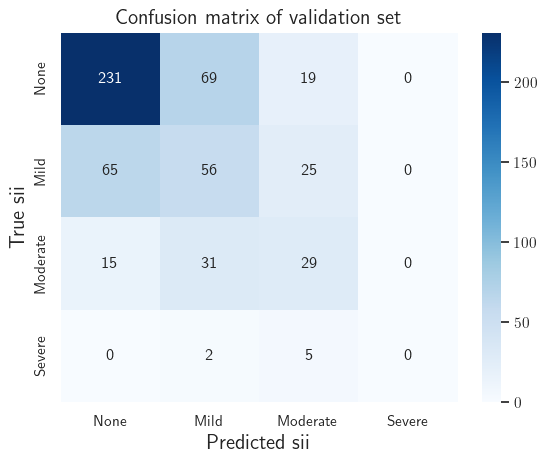

In [53]:
CM = confusion_matrix(y_val.tolist(), y_val_pred)

fig, ax = plt.subplots()

labels = ['None', 'Mild', 'Moderate', 'Severe']
sns.heatmap(CM, annot=True, cmap='Blues', fmt='.3g', ax=ax)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted sii', fontsize=15)
ax.set_ylabel('True sii', fontsize=15)
ax.set_title('Confusion matrix of validation set', fontsize=15)
plt.show()

In [50]:
print(classification_report(y_val, y_val_pred, target_names=['None', 'Mild', 'Moderate', 'Severe']))

              precision    recall  f1-score   support

        None       0.74      0.72      0.73       319
        Mild       0.38      0.40      0.39       146
    Moderate       0.41      0.43      0.42        75
      Severe       0.00      0.00      0.00         7

    accuracy                           0.59       547
   macro avg       0.38      0.39      0.38       547
weighted avg       0.59      0.59      0.59       547



In [23]:
#output = pd.DataFrame({'id': X_test.index.tolist(), 'sii': y_pred})

In [24]:
#output.to_csv('submission.csv', index=False)